# Offshore CIOPS Quantitative Runs

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import datetime as dt
import math

In [2]:
# round to 2 sig fig
def round_to_2(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+1)

def round_to_3(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+2)

In [3]:
meander = 0
init = 1
North = 2
Sshelf = 5
Sslope = 4
Offshore = 3
# sections = [North, Sshelf, Sslope, Offshore, meander]
# sec_name = ['north', 'south\nshelf', 'south\nslope', 'offshore', 'meander']

## summer 2017

In [4]:
data = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')

In [5]:
# init_t 3601 refers to the first hour of day 150 = 2017/04/01
# init_t 7992 refers to the last hour of day 333 = 2017/09/30
# the run itself starts on 7992

monS = ['apr', 'may', 'jun', 'jul', 'aug', 'sep']
mon_len = [30, 31, 30, 31, 31, 30]
h = 3601
sum_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
sum_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

In [ ]:
mon_sum = [np.sum(data.final_transp[(data.final_section!=0) & (np.isnan(data.final_section)==False) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]

saltdiv = 32
north = [np.sum(data.init_transp[(data.final_section==North) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] for i in range(len(sum_start))]
offshore = [np.sum(data.init_transp[(data.final_section==Offshore) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] for i in range(len(sum_start))]
cuc = [np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] for i in range(len(sum_start))]
south = [np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] for i in range(len(sum_start))]
fresh = [np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] for i in range(len(sum_start))]

In [19]:
mon_sum = [np.sum(data.final_transp[(data.final_section!=0) & (np.isnan(data.final_section)==False) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]

saltdiv = 32
north = [np.sum(data.final_transp[(data.final_section==North) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] for i in range(len(sum_start))]
offshore = [np.sum(data.final_transp[(data.final_section==Offshore) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] for i in range(len(sum_start))]
cuc = [np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] for i in range(len(sum_start))]
south = [np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] for i in range(len(sum_start))]
fresh = [np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] for i in range(len(sum_start))]

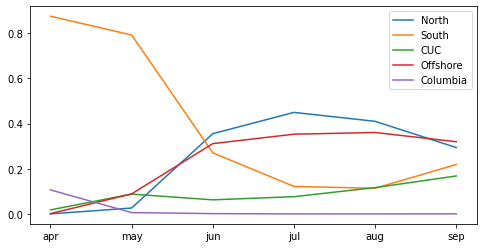

In [20]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(monS, north, label = "North")
ax.plot(monS, south, label = "South")
ax.plot(monS, cuc, label = "CUC")
ax.plot(monS, offshore, label='Offshore')
ax.plot(monS, fresh, label = "Columbia")
# ax.plot(monS, meander, label = "Strait Outflow")
ax.legend()

In [21]:
total = np.sum(mon_sum[2:])

north_bar = np.sum([north[2]*mon_sum[2]/total*100, north[3]*mon_sum[3]/total*100, north[4]*mon_sum[4]/total*100, north[5]*mon_sum[5]/total*100])
offshore_bar = np.sum([offshore[2]*mon_sum[2]/total*100, offshore[3]*mon_sum[3]/total*100, offshore[4]*mon_sum[4]/total*100, offshore[5]*mon_sum[5]/total*100])
cuc_bar = np.sum([cuc[2]*mon_sum[2]/total*100, cuc[3]*mon_sum[3]/total*100, cuc[4]*mon_sum[4]/total*100, cuc[5]*mon_sum[5]/total*100])
south_bar = np.sum([south[2]*mon_sum[2]/total*100, south[3]*mon_sum[3]/total*100, south[4]*mon_sum[4]/total*100, south[5]*mon_sum[5]/total*100]) 
fresh_bar = np.sum([fresh[2]*mon_sum[2]/total*100, fresh[3]*mon_sum[3]/total*100, fresh[4]*mon_sum[4]/total*100, fresh[5]*mon_sum[5]/total*100]) 

Text(0, 0.5, 'Percentage of JdF Inflow')

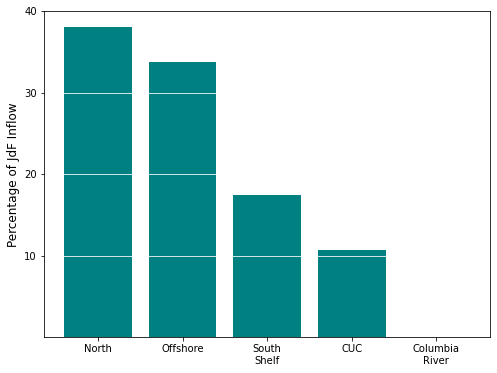

In [22]:
#bar plot of contribution for june, july, august, september
fig, ax = plt.subplots(1,1,figsize=(8,6))
sec_name = ['North', 'Offshore', 'South\nShelf', 'CUC', 'Columbia\nRiver']
# colors = ['magenta', 'orangered', 'teal', 'midnightblue']
colors = ['teal',  'teal',  'teal', 'teal', 'teal', 'teal']
ax.bar(sec_name,[north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar], color=colors)
ax.yaxis.set_ticks([10,20,30,40])
ax.grid(axis = 'y', color='white')
ax.set_ylabel('Percentage of JdF Inflow', fontsize=12)

In [23]:
[north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar]

[38.071321601910995,
 33.784668709189695,
 17.44001595402083,
 10.667422227262588,
 0.036571507615882536]

### how much is meandered?

In [36]:
# percentage meander
mean = [np.sum(data.final_transp[(data.final_section==0) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]
np.mean(np.array(mean[2:])/(np.array(mean[2:])+np.array(mon_sum[2:])))

0.8229404437875579

In [37]:
saltdiv=32
Mfresh = [np.sum(data.final_transp[(data.final_section == 0) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]   
Mupwelled = [np.sum(data.final_transp[(data.final_section == 0) & (data.init_salt > saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]                
Mdeep = [np.sum(data.final_transp[(data.final_section == 0) & (data.final_depth < -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]                

In [38]:
Mmon_sum = np.sum([Mfresh,Mupwelled,Mdeep], axis=0)

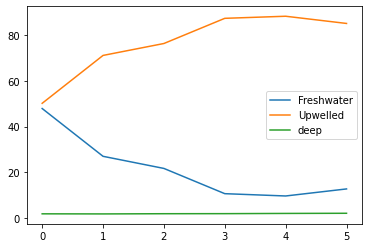

In [41]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(Mfresh/Mmon_sum*100, label='Freshwater')
ax.plot(Mupwelled/Mmon_sum*100, label='Upwelled')
ax.plot(Mdeep/Mmon_sum*100, label='deep')
ax.legend()

### Sv calcs

In [9]:
print('north = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('offshore = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('cuc = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('south = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('fresh = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')

north = 28.785348272370246 mSv
offshore = 25.54425258018518 mSv
cuc = 8.065532034610635 mSv
south = 13.18622290976587 mSv
fresh = 0.027651353808426187 mSv


In [10]:
print('cuc deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_depth <= -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('cuc shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('south deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth > -200) & (data.init_depth <= -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('south shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth > -200) & (data.init_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('offshore deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.init_depth <= -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('offshore shallow = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.init_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('offshore start deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.final_depth <= -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('north deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth <= -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('north shallow = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('meander = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==0) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')

cuc deep = 0.12298177853723945 mSv
cuc shallow = 7.942550256073397 mSv
south deep = 0.2409989751055626 mSv
south shallow = 12.972875288468734 mSv
offshore deep = 0.4069299092537078 mSv
offshore shallow = 25.137322670931468 mSv
offshore start deep = 7.932662876924874 mSv
north deep = 0.43319825257804107 mSv
north shallow = 28.352150019792198 mSv
meander = 352.1065512482824 mSv


## winter 2016/17

In [72]:
dataS= xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
data = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')

In [59]:
# init_t 3601 refers to the first hour of day 150 = 2017/04/01
# init_t 7992 refers to the last hour of day 333 = 2017/09/30
# the run itself starts on 7992

mon16 = ['oct16', 'nov16', 'dec16', 'jan17', 'feb17', 'mar17']
mon_len = [31, 30, 31, 31, 28, 31]
h = 3601
win_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
win_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

In [60]:
apr_may = mon_sum[:2]

In [73]:
mons = np.append(mon16, ['apr17', 'may17'])
saltdiv = 32

mon_sum = np.append([np.sum(data.final_transp[(data.final_section!=0) & (np.isnan(data.final_section)==False) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(win_start))],
                    apr_may)

cuc = np.append([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_t >= win_start[i]) & (data.final_depth <= -200) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                [np.sum(dataS.final_transp[np.logical_or((dataS.final_section==Sshelf),(dataS.final_section==Sslope)) & (dataS.final_depth <= -200) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0,1]])

south = np.append([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.init_t >= win_start[i]) & (data.final_depth > -200) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[np.logical_or((dataS.final_section==Sshelf),(dataS.final_section==Sslope)) & (dataS.init_salt >= saltdiv) & (dataS.init_t >= sum_start[i]) & (dataS.final_depth > -200) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0,1]])

fresh = np.append([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200)& (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[np.logical_or((dataS.final_section==Sshelf),(dataS.final_section==Sslope)) & (dataS.init_salt < saltdiv) & (dataS.final_depth > -200) &(dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0,1]])

north = np.append([np.sum(data.final_transp[(data.final_section==North) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[(dataS.final_section==North) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0,1]])

offshore = np.append([np.sum(data.final_transp[(data.final_section==3) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[(dataS.final_section==3) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0,1]])

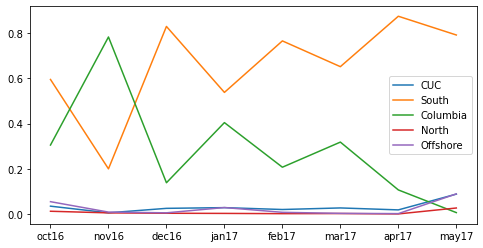

In [49]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(mons, cuc, label = "CUC")
ax.plot(mons, south, label = "South")
ax.plot(mons, fresh, label = "Columbia")
ax.plot(mons, north, label = "North")
ax.plot(mons, offshore, label = "Offshore")
ax.legend()

In [18]:
total = np.sum(mon_sum)
cuc_bar = np.sum([cuc[0]*mon_sum[0]/total*100, cuc[1]*mon_sum[1]/total*100, cuc[2]*mon_sum[2]/total*100, cuc[3]*mon_sum[3]/total*100, cuc[4]*mon_sum[4]/total*100, cuc[5]*mon_sum[5]/total*100,cuc[6]*mon_sum[6]/total*100,cuc[7]*mon_sum[7]/total*100])
south_bar = np.sum([south[0]*mon_sum[0]/total*100, south[1]*mon_sum[1]/total*100, south[2]*mon_sum[2]/total*100, south[3]*mon_sum[3]/total*100, south[4]*mon_sum[4]/total*100, south[5]*mon_sum[5]/total*100,south[6]*mon_sum[6]/total*100,south[7]*mon_sum[7]/total*100])
fresh_bar = np.sum([fresh[0]*mon_sum[0]/total*100, fresh[1]*mon_sum[1]/total*100, fresh[2]*mon_sum[2]/total*100, fresh[3]*mon_sum[3]/total*100, fresh[4]*mon_sum[4]/total*100, fresh[5]*mon_sum[5]/total*100,fresh[6]*mon_sum[6]/total*100,fresh[7]*mon_sum[7]/total*100])
north_bar = np.sum([north[0]*mon_sum[0]/total*100, north[1]*mon_sum[1]/total*100, north[2]*mon_sum[2]/total*100, north[3]*mon_sum[3]/total*100, north[4]*mon_sum[4]/total*100, north[5]*mon_sum[5]/total*100,north[6]*mon_sum[6]/total*100,north[7]*mon_sum[7]/total*100])
offshore_bar = np.sum([offshore[0]*mon_sum[0]/total*100, offshore[1]*mon_sum[1]/total*100, offshore[2]*mon_sum[2]/total*100, offshore[3]*mon_sum[3]/total*100, offshore[4]*mon_sum[4]/total*100, offshore[5]*mon_sum[5]/total*100,offshore[6]*mon_sum[6]/total*100,offshore[7]*mon_sum[7]/total*100])


Text(0, 0.5, 'Percentage of JdF Inflow')

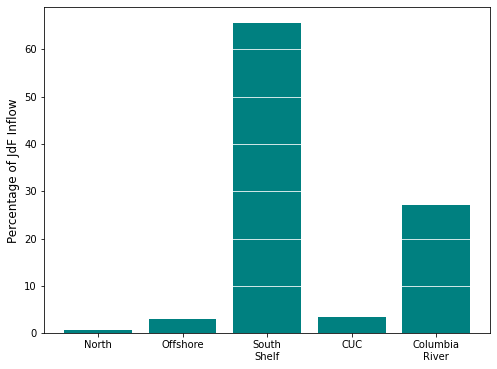

In [19]:
#bar plot of contribution for june, july, august, september
fig, ax = plt.subplots(1,1,figsize=(8,6))
sec_name = [ 'North', 'Offshore', 'South\nShelf', 'CUC', 'Columbia\nRiver']
colors = ['teal',  'teal',  'teal', 'teal', 'teal']
ax.bar(sec_name,[north_bar, offshore_bar, south_bar ,cuc_bar, fresh_bar], color=colors)
# ax.yaxis.set_ticks([10,20,30,40])
ax.grid(axis = 'y', color='white')
ax.set_ylabel('Percentage of JdF Inflow', fontsize=12)

In [20]:
[north_bar, offshore_bar, south_bar ,cuc_bar,fresh_bar]

[0.7588684749316418,
 2.971135534125656,
 65.64301929499757,
 3.44727164922571,
 27.17970504671942]

### how much is meandered?

In [62]:
# lets see how much is meandered from the different groups
saltdiv=32
Mfresh = [np.sum(data.final_transp[(data.final_section == 0) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]   
Mupwelled = [np.sum(data.final_transp[(data.final_section == 0) & (data.init_salt > saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]                
Mdeep = [np.sum(data.final_transp[(data.final_section == 0) & (data.final_depth < -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]  

In [63]:
Mmon_sum = np.sum([Mfresh,Mupwelled,Mdeep], axis=0)

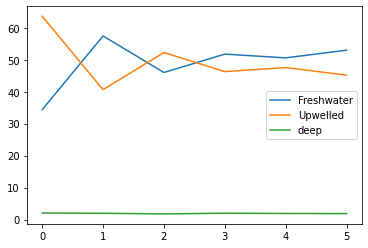

In [65]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(Mfresh/Mmon_sum*100, label='Freshwater')
ax.plot(Mupwelled/Mmon_sum*100, label='Upwelled')
ax.plot(Mdeep/Mmon_sum*100, label='deep')
ax.legend()

In [75]:
# percentage meander
mean = np.append([np.sum(data.final_transp[(data.final_section==0) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[(dataS.final_section==0) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [0,1]])
np.mean(np.array(mean)/(np.array(mean)+np.array(mon_sum)))

0.9013953874698539

### Sv

In [15]:
print('north = '+ str(np.mean(north*mon_sum/1000)) + ' mSv')
print('offshore = '+ str(np.mean(offshore*mon_sum/1000)) + ' mSv')
print('cuc = '+ str(np.mean(cuc*mon_sum/1000)) + ' mSv')
print('south = '+ str(np.mean(south*mon_sum/1000)) + ' mSv')
print('fresh = '+ str(np.mean(fresh*mon_sum/1000)) + ' mSv')

north = 0.3141154630447319 mSv
offshore = 1.2298305238659526 mSv
cuc = 1.4269156857979268 mSv
south = 27.171358519484976 mSv
fresh = 11.250389123014452 mSv


In [29]:
print('north = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('offshore = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('cuc = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('south = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.final_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('fresh = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')

north = 0.16135867255470182 mSv
offshore = 0.7578868226781977 mSv
cuc = 0.9111797224840742 mSv
south = 22.407815832254737 mSv
fresh = 13.873289497819423 mSv


In [40]:
print('cuc deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('cuc shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('south deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.final_depth > -200) & (data.init_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('south shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.final_depth > -200) & (data.init_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('offshore deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.init_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('offshore shallow = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.init_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('offshore start deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.final_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('north deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('north shallow = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('fresh deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('fresh shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')

print('meander = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==0) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')

cuc deep = 0.019325599872149102 mSv
cuc shallow = 0.8918541226119251 mSv
south deep = 0.5959344278625559 mSv
south shallow = 21.81188140439219 mSv
offshore deep = 0.013546291505999166 mSv
offshore shallow = 0.7443405311721984 mSv
offshore start deep = 0.031224974753504834 mSv
north deep = 0.0033482874546252196 mSv
north shallow = 0.15801038510007664 mSv
fresh deep = 0.0 mSv
fresh shallow = 13.873289497819423 mSv
meander = 398.1857958075713 mSv


In [46]:
np.mean(np.append([np.sum(data.final_transp[(data.final_section==0) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/1000 for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[(dataS.final_section==0) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/1000 for i in [0,1]]))

390.7458954940291

## winter 2017/18

In [76]:
data = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')

In [51]:
# init_t 3601 refers to the first hour of day 150 = 2017/04/01
# init_t 7992 refers to the last hour of day 333 = 2017/09/30
# the run itself starts on 7992

mon17 = ['oct17', 'nov17', 'dec17', 'jan18', 'feb18', 'mar18']
mon_len = [31, 30, 31, 31, 28, 31]
h = 3601
win_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
win_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

In [77]:
# mon_sum = [np.sum(data.final_transp[(data.final_section!=0) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(win_start))]
mon_sum = [np.sum(data.final_transp[(data.final_section!=0) & (np.isnan(data.final_section)==False) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(win_start))]

salt_div = 32
cuc = [np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_t >= win_start[i]) & (data.final_depth <= -200) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))]
south = [np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= salt_div) & (data.init_t >= win_start[i]) & (data.final_depth > -200) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))]
fresh = [np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < salt_div)  & (data.final_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))]
north = [np.sum(data.final_transp[(data.final_section==North) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))]
offshore = [np.sum(data.final_transp[(data.final_section==3) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))]

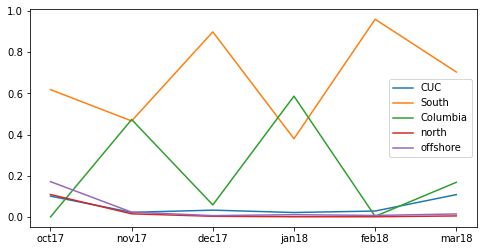

In [40]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(mon17, cuc, label = "CUC")
ax.plot(mon17, south, label = "South")
ax.plot(mon17, fresh, label = "Columbia")
ax.plot(mon17, north, label = "north")
ax.plot(mon17, offshore, label = "offshore")

ax.legend()

In [41]:
total = np.sum(mon_sum)
cuc_bar = np.sum([cuc[0]*mon_sum[0]/total*100, cuc[1]*mon_sum[1]/total*100, cuc[2]*mon_sum[2]/total*100, cuc[3]*mon_sum[3]/total*100, cuc[4]*mon_sum[4]/total*100, cuc[5]*mon_sum[5]/total*100]) #,cuc[6]*mon_sum[6]/total*100])
south_bar = np.sum([south[0]*mon_sum[0]/total*100, south[1]*mon_sum[1]/total*100, south[2]*mon_sum[2]/total*100, south[3]*mon_sum[3]/total*100, south[4]*mon_sum[4]/total*100, south[5]*mon_sum[5]/total*100]) #,cuc[6]*mon_sum[6]/total*100])
fresh_bar = np.sum([fresh[0]*mon_sum[0]/total*100, fresh[1]*mon_sum[1]/total*100, fresh[2]*mon_sum[2]/total*100, fresh[3]*mon_sum[3]/total*100, fresh[4]*mon_sum[4]/total*100, fresh[5]*mon_sum[5]/total*100])
north_bar = np.sum([north[0]*mon_sum[0]/total*100, north[1]*mon_sum[1]/total*100, north[2]*mon_sum[2]/total*100, north[3]*mon_sum[3]/total*100, north[4]*mon_sum[4]/total*100, north[5]*mon_sum[5]/total*100])
offshore_bar = np.sum([offshore[0]*mon_sum[0]/total*100, offshore[1]*mon_sum[1]/total*100, offshore[2]*mon_sum[2]/total*100, offshore[3]*mon_sum[3]/total*100, offshore[4]*mon_sum[4]/total*100, offshore[5]*mon_sum[5]/total*100])

Text(0, 0.5, 'Percentage of JdF Inflow')

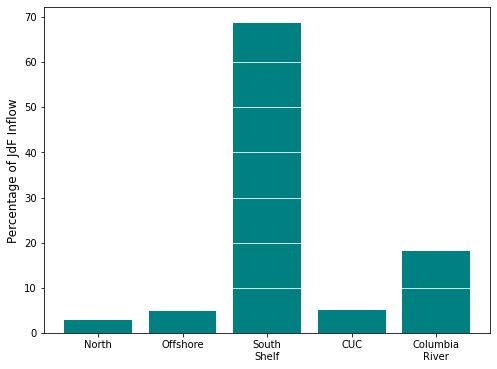

In [42]:
#bar plot of contribution for june, july, august, september
fig, ax = plt.subplots(1,1,figsize=(8,6))
sec_name = ['North', 'Offshore', 'South\nShelf', 'CUC', 'Columbia\nRiver']
colors = ['teal',  'teal',  'teal', 'teal', 'teal']
ax.bar(sec_name,[north_bar, offshore_bar, south_bar ,cuc_bar, fresh_bar], color=colors)
# ax.yaxis.set_ticks([10,20,30,40])
ax.grid(axis = 'y', color='white')
ax.set_ylabel('Percentage of JdF Inflow', fontsize=12)

In [43]:
[north_bar, offshore_bar, south_bar ,cuc_bar,fresh_bar]

[2.984656295912864,
 4.989913356906071,
 68.70822307908061,
 5.132452678277142,
 18.184754589823314]

### how much is meandered?

In [53]:
# lets see how much is meandered from the different groups
saltdiv=32
Mfresh = [np.sum(data.final_transp[(data.final_section == 0) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]   
Mupwelled = [np.sum(data.final_transp[(data.final_section == 0) & (data.init_salt > saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]                
Mdeep = [np.sum(data.final_transp[(data.final_section == 0) & (data.final_depth < -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]  

In [54]:
Mmon_sum = np.sum([Mfresh,Mupwelled,Mdeep], axis=0)

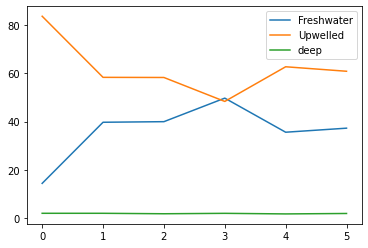

In [56]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(Mfresh/Mmon_sum*100, label='Freshwater')
ax.plot(Mupwelled/Mmon_sum*100, label='Upwelled')
ax.plot(Mdeep/Mmon_sum*100, label='deep')
ax.legend()

In [78]:
# percentage meander
mean = [np.sum(data.final_transp[(data.final_section==0) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-sum_start[i]+1) for i in range(len(win_start))]
np.mean(np.array(mean)/(np.array(mean)+np.array(mon_sum)))

0.8930851609650512

### Sv

In [25]:
print('north = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('offshore = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('cuc = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('south = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.final_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('fresh = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')

north = 1.3802585523807231 mSv
offshore = 2.30759253450384 mSv
cuc = 2.373510046561217 mSv
south = 30.43437171254573 mSv
fresh = 9.749409493205969 mSv


In [38]:
print('cuc deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('cuc shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('south deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.final_depth > -200) & (data.init_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('south shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.final_depth > -200) & (data.init_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('offshore deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.init_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('offshore shallow = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.init_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('offshore start deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.final_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('north deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('north shallow = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('fresh deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('fresh shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')

print('meander = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==0) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')

cuc deep = 0.04484482493058107 mSv
cuc shallow = 2.3286652216306365 mSv
south deep = 0.7069647195430726 mSv
south shallow = 29.727406993002656 mSv
offshore deep = 0.036264999543405875 mSv
offshore shallow = 2.271327534960434 mSv
offshore start deep = 0.07138265217474533 mSv
north deep = 0.02312912961191182 mSv
north shallow = 1.3571294227688115 mSv
fresh deep = 0.00555084768922021 mSv
fresh shallow = 9.743858645516749 mSv
meander = 392.98160959128614 mSv


# bring it all together

In [4]:
mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
h = 3601
start = [h+24*i for i in range(182)]

fresh16 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_salt < 32.4) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
cuc16 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_salt >= 32.4) & (mydata.final_depth <= -200) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
south16 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_salt >= 32.4) & (mydata.final_depth > -200) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
north16 = [np.sum(mydata.final_transp[(mydata.final_section==North) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
offshore16 = [np.sum(mydata.final_transp[(mydata.final_section==3) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
offshoredeep16 = [np.sum(mydata.final_transp[(mydata.final_section==3) & (mydata.final_depth <= -200) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
 

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
h = 3601
start = [h+24*i for i in range(183)]

freshS = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_salt < 32.4) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
cucS = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_salt >= 32.4) & (mydata.final_depth <= -200) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
southS = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_salt >= 32.4) & (mydata.final_depth > -200) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
northS = [np.sum(mydata.final_transp[(mydata.final_section==North) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
offshoreS = [np.sum(mydata.final_transp[(mydata.final_section==3) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
offshoredeepS = [np.sum(mydata.final_transp[(mydata.final_section==3) & (mydata.final_depth <= -200) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
h = 3601
start = [h+24*i for i in range(182)]

fresh17 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_salt < 32.4) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
cuc17 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_salt >= 32.4) & (mydata.final_depth <= -200) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
south17 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_salt >= 32.4) & (mydata.final_depth > -200) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
north17 = [np.sum(mydata.final_transp[(mydata.final_section==North) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
offshore17 = [np.sum(mydata.final_transp[(mydata.final_section==3) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
offshoredeep17 = [np.sum(mydata.final_transp[(mydata.final_section==3) & (mydata.final_depth <= -200) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]


fresh = np.append(np.append(fresh16, freshS), fresh17)
south = np.append(np.append(south16, southS), south17)
north = np.append(np.append(north16, northS), north17)
cuc = np.append(np.append(cuc16, cucS), cuc17)
offshore = np.append(np.append(offshore16, offshoreS), offshore17)
offshoredeep = np.append(np.append(offshoredeep16, offshoredeepS), offshoredeep17)

In [5]:
dates = [dt.datetime(2016,10,1)+dt.timedelta(days=i) for i in range(len(cuc))]
# dates = [dt.datetime(2016,10,1)+dt.timedelta(days=i) for i in range(len(deep_cuc))]

In [16]:
dates[364]

datetime.datetime(2017, 9, 30, 0, 0)

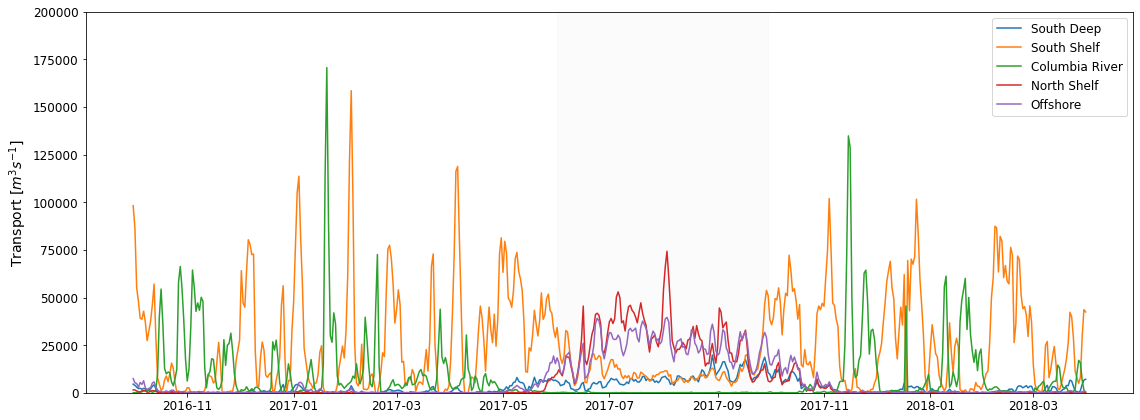

In [20]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
plt.rcParams['font.size'] = 12
ax.plot(dates, cuc, label = "South Deep")
ax.plot(dates, south, label = "South Shelf")
ax.plot(dates, fresh, label = "Columbia River")
ax.plot(dates, north, label = "North Shelf")
ax.plot(dates, offshore, label = "Offshore")
ax.legend(loc='upper right')
ax.set_ylabel('Transport [$m^{3}s^{-1}$]',fontsize=14)
# ax.set_ylim([0,55000]);
ax.set_ylim([0,200000])

ax.fill_between(np.array(dates), 0,200000, where=(np.array(dates)<=dates[364])&(np.array(dates)>dates[242]), color='whitesmoke', alpha=0.4)

plt.tight_layout()
plt.savefig("./figures/dailyWMtoJRT.png")



Text(0, 0.5, 'Cumulative Transport [$m^{3}s^{-1}$]')

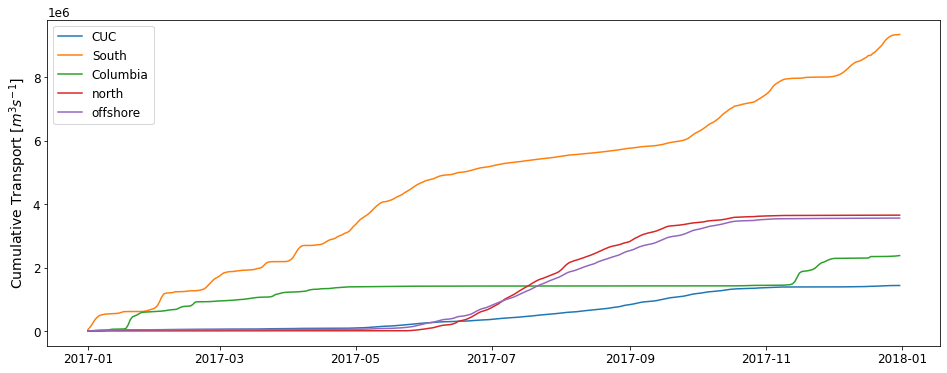

In [16]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
plt.rcParams['font.size'] = 12
ax.plot(dates[92:457], np.cumsum(cuc[92:457]), label = "CUC")
ax.plot(dates[92:457], np.cumsum(south[92:457]), label = "South")
ax.plot(dates[92:457], np.cumsum(fresh[92:457]), label = "Columbia")
ax.plot(dates[92:457], np.cumsum(north[92:457]), label = "north")
ax.plot(dates[92:457], np.cumsum(offshore[92:457]), label = "offshore")
ax.legend(loc='upper left')
ax.set_ylabel('Cumulative Transport [$m^{3}s^{-1}$]',fontsize=14)

In [7]:
# lets calculate the peason's correlation coefficient between north and offhsore in the summer
corr, _ = pearsonr(north[243:364], offshore[243:364])
print('Pearsons correlation with offshore: %.3f' % corr)
corr, _ = pearsonr(north[243:364], cuc[243:364])
print('Pearsons correlation with cuc: %.3f' % corr)
corr, _ = pearsonr(north[243:364], south[243:364])
print('Pearsons correlation with south: %.3f' % corr)
corr, _ = pearsonr(cuc[243:364], south[243:364])
print('Pearsons correlation cuc and south summer: %.3f' % corr)

Pearsons correlation with offshore: 0.726
Pearsons correlation with cuc: 0.023
Pearsons correlation with south: -0.161
Pearsons correlation cuc and south summer: 0.264


In [16]:
corr, _ = pearsonr(np.append(fresh[:215],fresh[364:]), np.append(south[:215],south[364:]))
print('Pearsons correlation fresh and south winter: %.3f' % corr)
corr, _ = pearsonr(np.append(cuc[:215],cuc[364:]), np.append(south[:215],south[364:]))
print('Pearsons correlation cuc and south winter: %.3f' % corr)
corr, _ = pearsonr(np.append(cuc[:215],cuc[364:]), np.append(fresh[:215],fresh[364:]))
print('Pearsons correlation cuc and fresh winter: %.3f' % corr)

Pearsons correlation fresh and south winter: -0.432
Pearsons correlation cuc and south winter: 0.507
Pearsons correlation cuc and fresh winter: -0.320


In [70]:
# lets calculate the peason's correlation coefficient between north and offhsore in the summer
corr, _ = pearsonr(offshoredeep[243:364], cuc[243:364])
print('Pearsons correlation with offshore: %.3f' % corr)
corr, _ = pearsonr(north[243:364], offshoredeep[243:364])
print('Pearsons correlation with cuc: %.3f' % corr)
# corr, _ = pearsonr(north[243:364], [243:364])
# print('Pearsons correlation with south: %.3f' % corr)

Pearsons correlation with offshore: -0.097
Pearsons correlation with cuc: 0.736


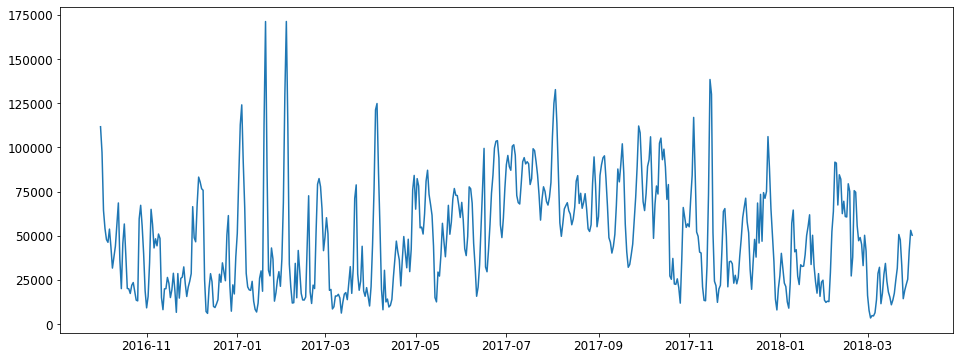

In [71]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
ax.plot(dates, np.sum([cuc,south,fresh,north,offshore],axis=0))
# ax.set_ylim([0,90000]);